In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
SAMPLE_SIZE = 250
IMAGE_SIZE = 96

In [3]:
os.listdir('../input/nonsegmentedv2')

['Scentless Mayweed',
 'Common wheat',
 'Charlock',
 'Black-grass',
 'Sugar beet',
 'Loose Silky-bent',
 'Maize',
 'Cleavers',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Shepherd’s Purse']

In [4]:

folder_list = os.listdir('../input/nonsegmentedv2')

total_images = 0


for folder in folder_list:
  
    path = '../input/nonsegmentedv2/' + str(folder)
    
    images_list = os.listdir(path)
   
    num_images = len(images_list)
    
    total_images = total_images + num_images
   
    print(str(folder) + ':' + ' ' + str(num_images))
    
print('\n')

print('Total Images: ', total_images)
    

Scentless Mayweed: 607
Common wheat: 253
Charlock: 452
Black-grass: 309
Sugar beet: 463
Loose Silky-bent: 762
Maize: 257
Cleavers: 335
Common Chickweed: 713
Fat Hen: 538
Small-flowered Cranesbill: 576
Shepherd’s Purse: 274


Total Images:  5539


In [5]:

all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)


In [6]:

!ls

__notebook_source__.ipynb  all_images_dir


In [7]:



folder_list = os.listdir('../input/nonsegmentedv2')

for folder in folder_list:
    
   
    path = '../input/nonsegmentedv2/' + str(folder)

   
    file_list = os.listdir(path)

    
    for fname in file_list:

        
        src = os.path.join(path, fname)
        
       
        new_fname = str(folder) + '_' + fname
        
    
        dst = os.path.join(all_images_dir, new_fname)
       
        shutil.copyfile(src, dst)



In [8]:

len(os.listdir('all_images_dir'))

5539

In [9]:

image_list = os.listdir('all_images_dir')
df_data = pd.DataFrame(image_list, columns=['image_id'])

df_data.head()

image_id
0  Common Chickweed_162.png
1  Loose Silky-bent_634.png
2  Loose Silky-bent_622.png
3  Common Chickweed_279.png
4              Maize_18.png

In [10]:
def extract_target(x):
    

    a = x.split('_')
    
    target = a[0]
    
    return target



df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head()

image_id            target
0  Common Chickweed_162.png  Common Chickweed
1  Loose Silky-bent_634.png  Loose Silky-bent
2  Loose Silky-bent_622.png  Loose Silky-bent
3  Common Chickweed_279.png  Common Chickweed
4              Maize_18.png             Maize

In [12]:



def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    

    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

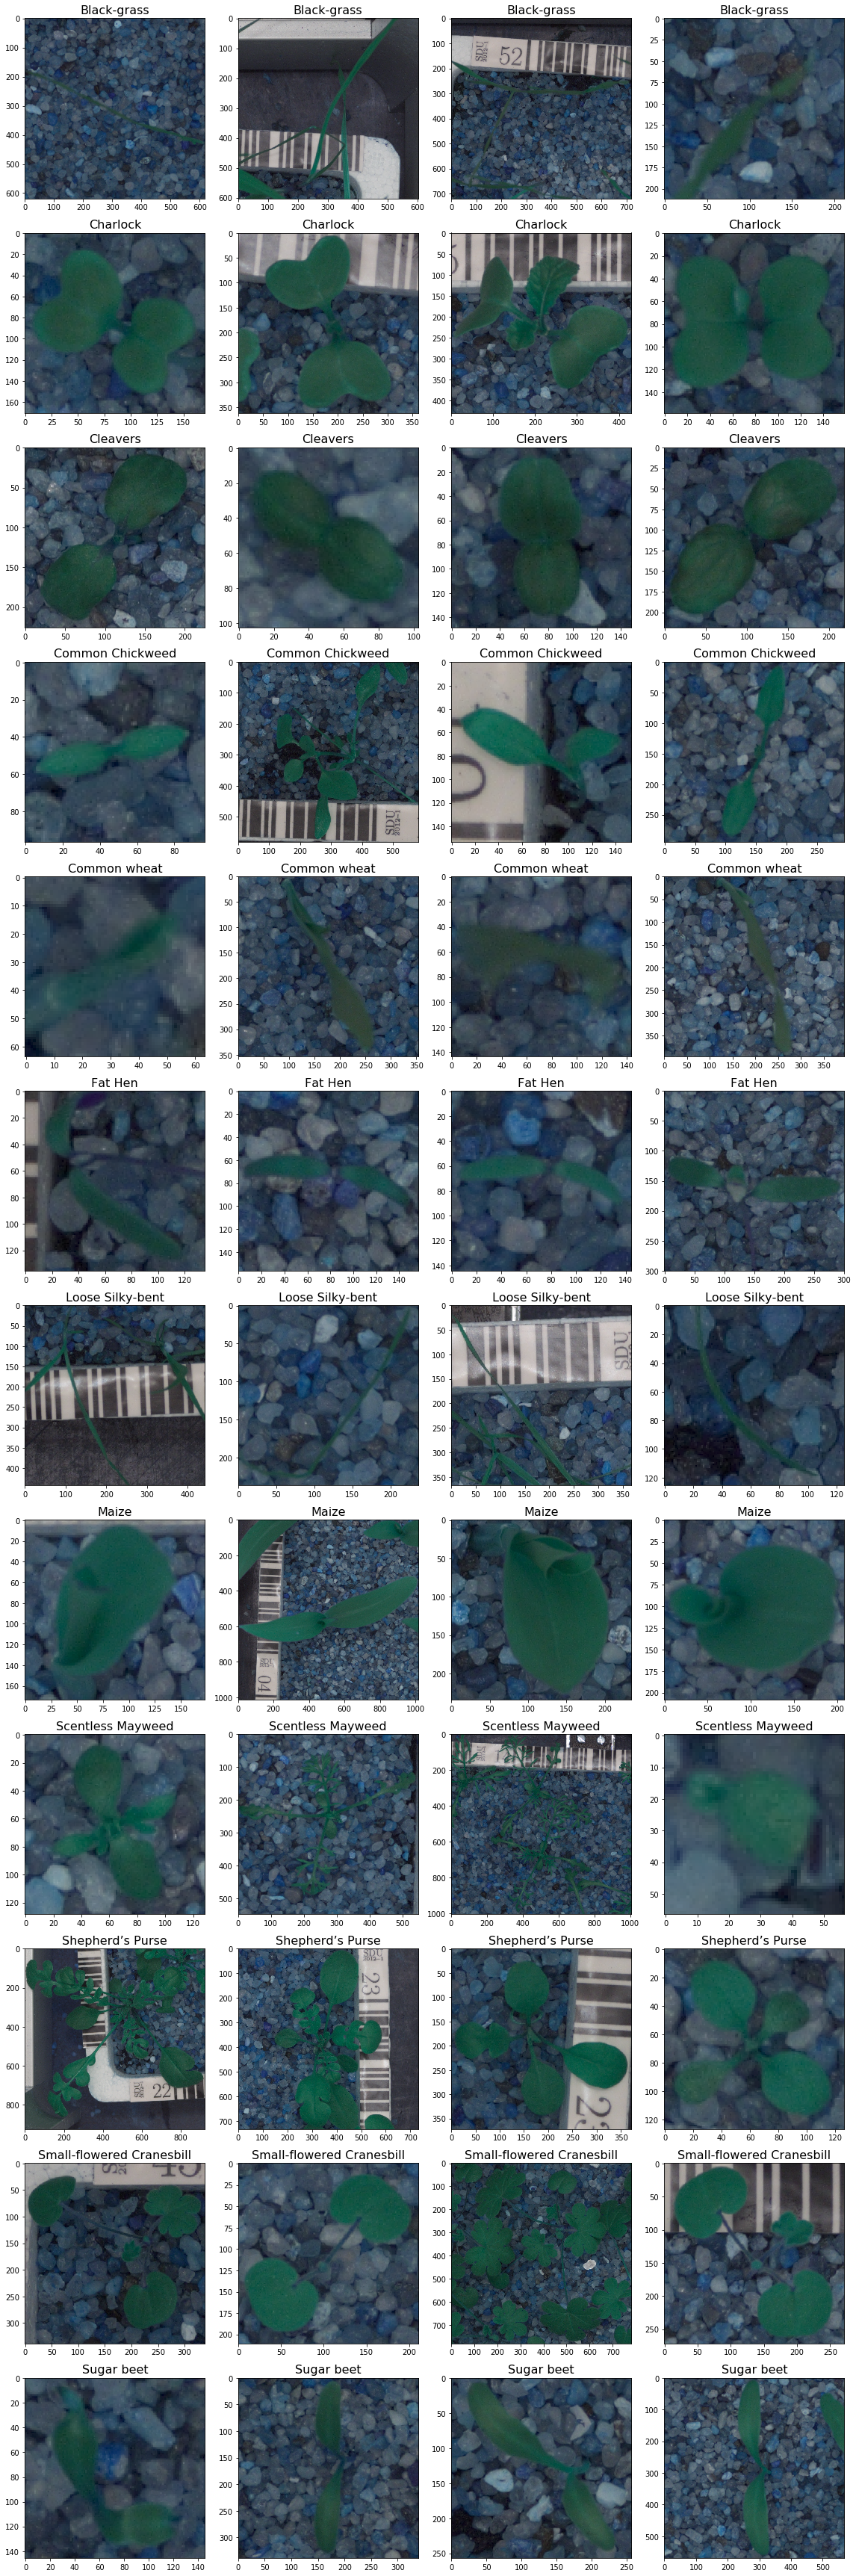

In [13]:
IMAGE_PATH = 'all_images_dir/'

draw_category_images('target',4, df_data, IMAGE_PATH)

In [14]:
df_data['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherd’s Purse             274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

In [16]:


target_list = os.listdir('../input/nonsegmentedv2')

for target in target_list:

    
    df = df_data[df_data['target'] == target].sample(SAMPLE_SIZE, random_state=101)
    
    
    if target == target_list[0]:
        df_sample = df
    else:
        
        df_sample = pd.concat([df_sample, df], axis=0).reset_index(drop=True)


In [17]:


df_sample['target'].value_counts()

Common Chickweed             250
Loose Silky-bent             250
Sugar beet                   250
Fat Hen                      250
Common wheat                 250
Black-grass                  250
Scentless Mayweed            250
Shepherd’s Purse             250
Small-flowered Cranesbill    250
Charlock                     250
Maize                        250
Cleavers                     250
Name: target, dtype: int64

In [18]:

y = df_sample['target']

df_train, df_val = train_test_split(df_sample, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2700, 2)
(300, 2)


In [21]:
folder_list = os.listdir('../input/nonsegmentedv2')

folder_list

['Scentless Mayweed',
 'Common wheat',
 'Charlock',
 'Black-grass',
 'Sugar beet',
 'Loose Silky-bent',
 'Maize',
 'Cleavers',
 'Common Chickweed',
 'Fat Hen',
 'Small-flowered Cranesbill',
 'Shepherd’s Purse']

In [22]:

base_dir = 'base_dir'
os.mkdir(base_dir)


train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)


val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)



for folder in folder_list:
    
    folder = os.path.join(train_dir, str(folder))
    os.mkdir(folder)



for folder in folder_list:
    
    folder = os.path.join(val_dir, str(folder))
    os.mkdir(folder)

In [23]:

os.listdir('base_dir/train_dir')

['Maize',
 'Fat Hen',
 'Shepherd’s Purse',
 'Sugar beet',
 'Cleavers',
 'Small-flowered Cranesbill',
 'Charlock',
 'Loose Silky-bent',
 'Common Chickweed',
 'Scentless Mayweed',
 'Black-grass',
 'Common wheat']

In [24]:

df_data.set_index('image_id', inplace=True)

In [25]:
df_data.head()

target
image_id                                  
Common Chickweed_162.png  Common Chickweed
Loose Silky-bent_634.png  Loose Silky-bent
Loose Silky-bent_622.png  Loose Silky-bent
Common Chickweed_279.png  Common Chickweed
Maize_18.png                         Maize

In [26]:

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


for image in train_list:
    
    
    fname = image
    
    folder = df_data.loc[image,'target']
    
    
    
    src = os.path.join(all_images_dir, fname)
    
    dst = os.path.join(train_dir, folder, fname)
    
    image = cv2.imread(src)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    cv2.imwrite(dst, image)
        
    



for image in val_list:
    
    
    fname = image
   
    folder = df_data.loc[image,'target']
    

    
    src = os.path.join(all_images_dir, fname)
    
    dst = os.path.join(val_dir, folder, fname)
    
    
    image = cv2.imread(src)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    cv2.imwrite(dst, image)

    

In [29]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'


num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [30]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 2700 images belonging to 12 classes.
Found 300 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


In [31]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 41, 64)        36928     
__________

In [32]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [33]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=40, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/40
266/270 [============================>.] - ETA: 0s - loss: 2.4499 - acc: 0.1023
Epoch 00001: val_acc improved from -inf to 0.17667, saving model to model.h5
270/270 [==============================] - 12s 44ms/step - loss: 2.4475 - acc: 0.1030 - val_loss: 2.2160 - val_acc: 0.1767
Epoch 2/40
268/270 [============================>.] - ETA: 0s - loss: 1.9585 - acc: 0.2593
Epoch 00002: val_acc improved from 0.17667 to 0.32333, saving model to model.h5
270/270 [==============================] - 6s 21ms/step - loss: 1.9582 - acc: 0.2596 - val_loss: 1.6924 - val_acc: 0.3233
Epoch 3/40
267/270 [============================>.] - ETA: 0s - loss: 1.7188 - acc: 0.3307
Epoch 00003: val_acc improved from 0.32333 to 0.43667, saving model to model.h5
270/270 [==============================] - 5s 20ms/step - loss: 1.7213 - acc: 0.3307 - val_loss: 1.4721 - val_acc: 0.4367
Epoch 4/40
266/270 [============================>.] - ETA: 0s - loss: 1.5623 - acc: 0.4075
Epoch 00004: val_acc improved fr

Epoch 30/40
268/270 [============================>.] - ETA: 0s - loss: 0.1567 - acc: 0.9407
Epoch 00030: val_acc did not improve from 0.77333
270/270 [==============================] - 5s 20ms/step - loss: 0.1576 - acc: 0.9400 - val_loss: 1.0820 - val_acc: 0.7667
Epoch 31/40
267/270 [============================>.] - ETA: 0s - loss: 0.1698 - acc: 0.9363
Epoch 00031: val_acc did not improve from 0.77333
270/270 [==============================] - 5s 20ms/step - loss: 0.1710 - acc: 0.9356 - val_loss: 1.1168 - val_acc: 0.7500
Epoch 32/40
267/270 [============================>.] - ETA: 0s - loss: 0.1578 - acc: 0.9367
Epoch 00032: val_acc did not improve from 0.77333

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
270/270 [==============================] - 5s 19ms/step - loss: 0.1570 - acc: 0.9374 - val_loss: 1.2147 - val_acc: 0.7467
Epoch 33/40
269/270 [============================>.] - ETA: 0s - loss: 0.1472 - acc: 0.9405
Epoch 00033: val_acc did not improv

In [34]:

model.metrics_names

['loss', 'acc']

In [35]:

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 1.0262855419599282
val_acc: 0.7733333333333333


<Figure size 432x288 with 0 Axes>

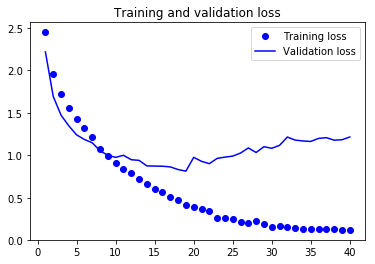

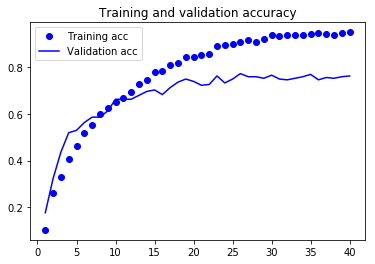

<Figure size 432x288 with 0 Axes>

In [36]:


import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [37]:

predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

300/300 [==============================] - 1s 4ms/step


In [38]:
predictions.shape

(300, 12)

In [39]:

test_gen.class_indices


{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherd’s Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [40]:

class_dict = train_gen.class_indices


cols = class_dict.keys()

df_preds = pd.DataFrame(predictions, columns=cols)

df_preds.head()

Black-grass      ...         Sugar beet
0     0.596923      ...       6.251327e-04
1     0.577343      ...       2.564293e-05
2     0.479816      ...       7.926347e-07
3     0.337175      ...       4.219060e-06
4     0.367038      ...       3.923657e-06

[5 rows x 12 columns]

### Create a Confusion Matrix

In [41]:

test_labels = test_gen.classes

In [42]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [43]:

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

Confusion matrix, without normalization
[[14  0  0  0  2  0  9  0  0  0  0  0]
 [ 0 22  1  0  0  0  0  1  0  0  1  0]
 [ 0  0 24  0  0  0  0  0  1  0  0  0]
 [ 0  0  0 21  0  0  0  3  0  0  1  0]
 [ 1  0  1  0 20  0  0  1  0  0  0  2]
 [ 1  0  4  0  1 15  1  0  1  1  0  1]
 [ 9  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  1  0  1  0  0 21  2  0  0  0]
 [ 0  0  0  2  1  1  0  0 20  0  0  1]
 [ 0  1  0  1  0  0  0  0  3 19  1  0]
 [ 0  1  0  1  0  0  0  0  0  0 23  0]
 [ 0  1  0  0  2  1  0  1  2  1  0 17]]


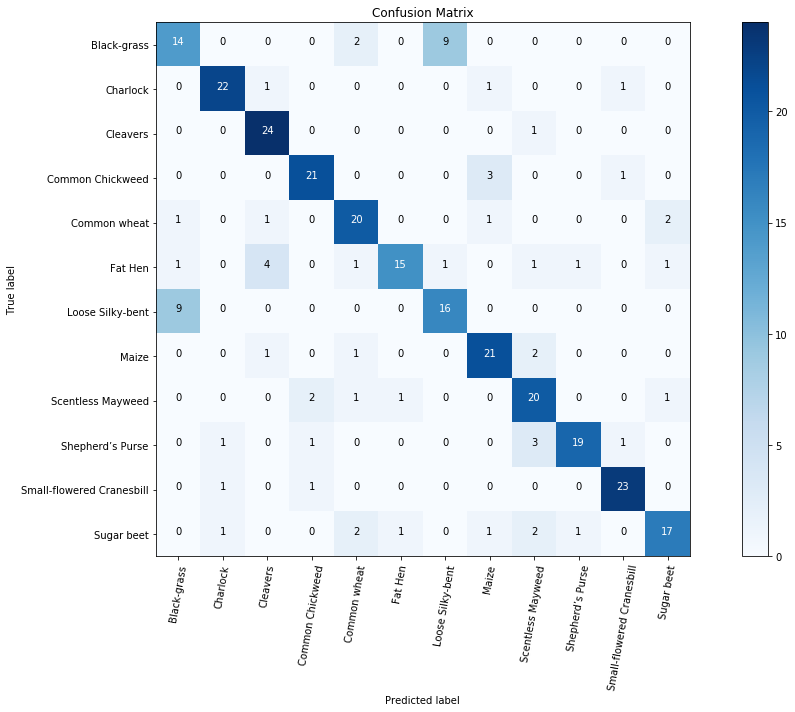

In [44]:
.
cm_plot_labels = cols

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
